In [1]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt  # make sure model class is accessible
import json
import os
import torch.nn.functional as F

In [2]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [9]:
color_rgb_dict = {
    'red': [1, 0, 0],
    'blue': [0, 0, 1],
    'green': [0, 1, 0],
    'yellow': [1, 1, 0],
    'orange': [1, 0.5, 0],
    'purple': [0.5, 0, 0.5],
    'cyan': [0, 1, 1],
    'magenta': [1, 0, 1]
}
color2idx = {k: i for i, k in enumerate(color_rgb_dict)}

In [ ]:
import torch
from Coloured_Polygon_Generation.model import UNet


# Use CPU since you're on a Mac
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Initialize model and move to device
model = UNet(color2idx=color2idx, color_embedding_dim=32).to(device)

# Load the trained weights
model_path = '/Users/salonisahal/Col_Polygon_Gen/Models/colored_polygon_unet.pth'
model.load_state_dict(torch.load(model_path, map_location=device))

# Set the model to evaluation mode
model.eval()


/var/folders/gn/0625w7jn7mscm9f5g6pchy800000gn/T/ipykernel_80077/1231688593.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

UNet(
  (embed_color): Linear(in_features=8, out_features=32, bias=True)
  (encoder1): ConvBlock(
    (block): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): ConvBlock(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

/var/folders/gn/0625w7jn7mscm9f5g6pchy800000gn/T/ipykernel_80077/945853507.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/Users/salo

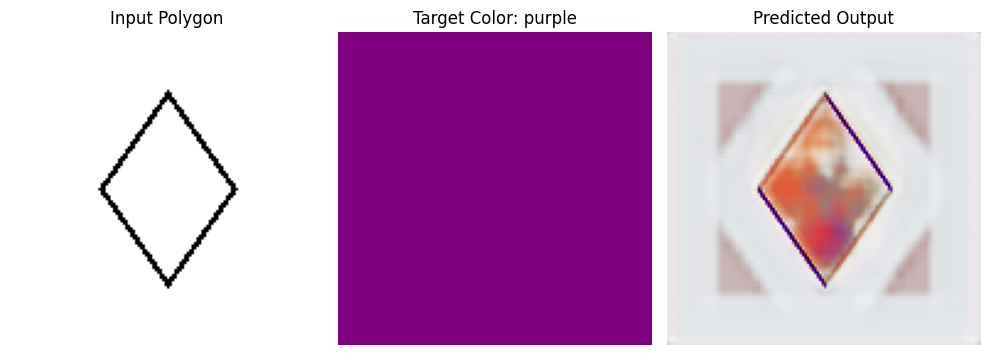

In [15]:
from PIL import Image
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# -------- Load and preprocess input polygon --------
polygon_img_path = "/Users/salonisahal/Col_Polygon_Gen/Data/training/inputs/diamond.png"
color_name = 'purple'



# Load image
img = Image.open(polygon_img_path).convert('L')
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
img_tensor = transform(img).unsqueeze(0)  # [1, 1, H, W]

# Encode color
color_idx = color2idx[color_name]
color_tensor = F.one_hot(torch.tensor([color_idx]), num_classes=len(color2idx)).float()

# -------- Run Inference --------
model = UNet(color2idx=color2idx,color_embedding_dim=32)
model.load_state_dict(torch.load("/Users/salonisahal/Col_Polygon_Gen/Models/colored_polygon_unet.pth", map_location="cpu"))
model.eval()

with torch.no_grad():
    output = model(img_tensor, color_tensor)

# -------- Visualize --------
output_img = (output.squeeze().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
target_rgb = np.array(color_rgb_dict.get(color_name, [1, 1, 1]))  # fallback: white

plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.title("Input Polygon")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title(f"Target Color: {color_name}")
plt.imshow(np.ones((128, 128, 3)) * target_rgb)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Output")
plt.imshow(output_img)
plt.axis('off')

plt.tight_layout()
plt.show()
